# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split as split

In [17]:
car=pd.read_csv("https://raw.githubusercontent.com/jac7az/linearModels/refs/heads/main/lab/data/cars_hw.csv")
car['No_of_Owners']=car['No_of_Owners'].replace({'1st':1,"2nd":2,'3rd':3})
car

<ipython-input-17-ff981915434a>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  car['No_of_Owners']=car['No_of_Owners'].replace({'1st':1,"2nd":2,'3rd':3})


,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1,5,petrol,5-Speed,Manual,515000
...,...,...,...,...,...,...,...,...,...,...,...,...
971,972,Hyundai,2018,white,sedan,23869,1,5,petrol,6-Speed,Automatic,956000
972,973,Hyundai,2019,white,sedan,14831,1,5,petrol,6-Speed,Automatic,1027000
973,974,Hyundai,2014,silver,sedan,52846,1,5,petrol,4-Speed,Automatic,736000
974,975,Ford,2020,white,crossover,28335,2,5,diesel,5-Speed,Automatic,749000


<Axes: xlabel='Mileage_Run', ylabel='Density'>

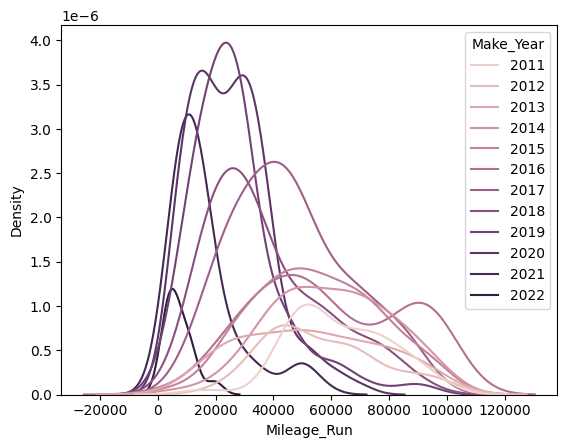

In [18]:
sns.kdeplot(car,x='Mileage_Run',hue='Make_Year')

<Axes: xlabel='Mileage_Run', ylabel='Price'>

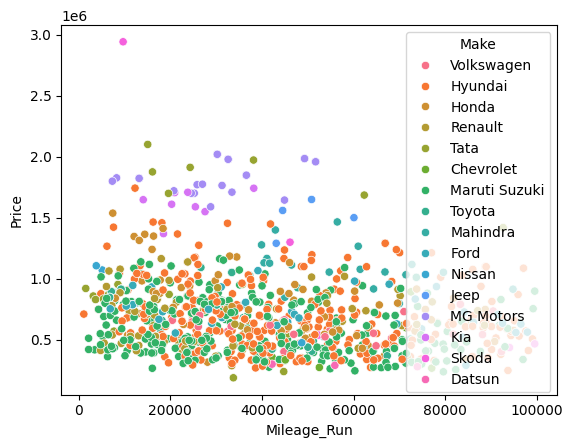

In [19]:
sns.scatterplot(car,x='Mileage_Run',y='Price',hue='Make')

In [20]:
car.groupby('Fuel_Type')['Transmission_Type'].count()

,Transmission_Type
Fuel_Type,
diesel,191
petrol,783
petrol+cng,2


In [21]:
car[['Make','Color']].value_counts()

Make           Color 
Hyundai        white     69
               red       66
Maruti Suzuki  grey      64
               blue      62
Hyundai        grey      57
                         ..
Skoda          silver     1
Toyota         grey       1
               blue       1
Tata           yellow     1
Volkswagen     white      1
Name: count, Length: 111, dtype: int64

In [22]:
xtrain,xtest,ytrain,ytest=split(car.iloc[:,:-1],car['Price'],test_size=0.2,random_state=90834678)
body=pd.get_dummies(xtrain[['Make_Year','Body_Type']],dtype='int',columns=['Make_Year','Body_Type'])
make=pd.get_dummies(xtrain[['Make','Color']],dtype='int',columns=['Make','Color'])
trans=pd.get_dummies(xtrain[['Fuel_Type','Transmission','Transmission_Type']],dtype='int',columns=['Fuel_Type','Transmission','Transmission_Type'])
rsmet=[]
r2t=[]
rsme=[]
r2=[]

bodyT=pd.get_dummies(xtest[['Make_Year','Body_Type']],dtype='int',columns=['Make_Year','Body_Type'])
makeT=pd.get_dummies(xtest[['Make','Color']],dtype='int',columns=['Make','Color'])
makeT=makeT.reindex(columns=make.columns,fill_value=0)
transT=pd.get_dummies(xtest[['Fuel_Type','Transmission','Transmission_Type']],dtype='int',columns=['Fuel_Type','Transmission','Transmission_Type'])
transT=transT.reindex(columns=trans.columns,fill_value=0)

bodyreg=LinearRegression(fit_intercept=False).fit(body,ytrain)
bodypredt=bodyreg.predict(body)
bodypred=bodyreg.predict(bodyT)
rsmet.append(np.sqrt(np.sum((bodypredt-ytrain)**2)/len(ytrain)))
r2t.append(bodyreg.score(body,ytrain))
rsme.append(np.sqrt(np.sum((bodypred-ytest)**2)/len(ytest)))
r2.append(bodyreg.score(bodyT,ytest))

makereg=LinearRegression(fit_intercept=False).fit(make,ytrain)
makepredt=makereg.predict(make)
makepred=makereg.predict(makeT)
rsmet.append(np.sqrt(np.sum((makepredt-ytrain)**2)/len(ytrain)))
r2t.append(makereg.score(make,ytrain))
rsme.append(np.sqrt(np.sum((makepred-ytest)**2)/len(ytest)))
r2.append(makereg.score(makeT,ytest))

transreg=LinearRegression(fit_intercept=False).fit(trans,ytrain)
transpredt=transreg.predict(trans)
transpred=transreg.predict(transT)
rsmet.append(np.sqrt(np.sum((transpredt-ytrain)**2)/len(ytrain)))
r2t.append(transreg.score(trans,ytrain))
rsme.append(np.sqrt(np.sum((transpred-ytest)**2)/len(ytest)))
r2.append(transreg.score(transT,ytest))

num=xtrain[['Mileage_Run','No_of_Owners','Seating_Capacity']]
numT=xtest[['Mileage_Run','No_of_Owners','Seating_Capacity']]
num=pd.get_dummies(num,columns=['No_of_Owners','Seating_Capacity'])
numT=pd.get_dummies(numT,columns=['No_of_Owners','Seating_Capacity'])
numT=numT.reindex(columns=num.columns,fill_value=0)
numreg=LinearRegression(fit_intercept=False).fit(num,ytrain)
numpredt=numreg.predict(num)
numpred=numreg.predict(numT)
rsmet.append(np.sqrt(np.sum((numpredt-ytrain)**2)/len(ytrain)))
r2t.append(numreg.score(num,ytrain))
rsme.append(np.sqrt(np.sum((numpred-ytest)**2)/len(ytest)))
r2.append(numreg.score(numT,ytest))

print("R2 Train:",r2t,"\n","RSME Train:",rsmet,"\n","R2 Test:",r2,"\n","RSME Test:",rsme)
#My R2 are all pretty bad, but the model with car make + color does the best.
  #Make does have a big influence on price compared to the other variables I chose, and color could drive demand up for a certain kind of car.
#The R2 for num is VERY low though.
#Having lower RSME and R2 for train means that the model isn't capturing patterns well

R2 Train: [0.6361997086577389, 0.5431504478000448, 0.4134101532177338, 0.06582130255980889] 
 RSME Train: [np.float64(217013.32129201747), np.float64(243187.62658484315), np.float64(275563.7861706009), np.float64(347752.1728334374)] 
 R2 Test: [0.6586759754819582, 0.5564802260353351, 0.32991984981776123, 0.06884365957286509] 
 RSME Test: [np.float64(230239.3467621071), np.float64(262453.6452914177), np.float64(322596.3817721985), np.float64(380283.44361037685)]


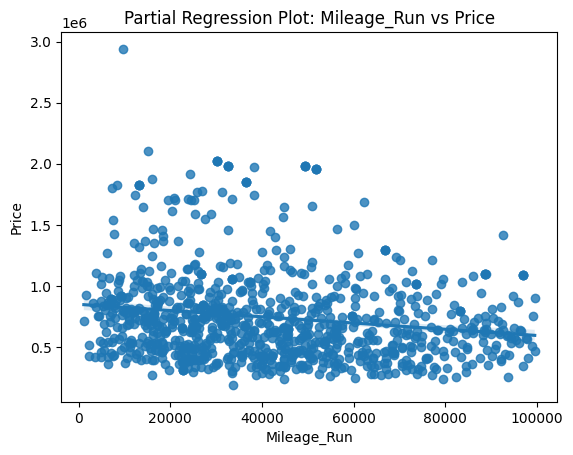

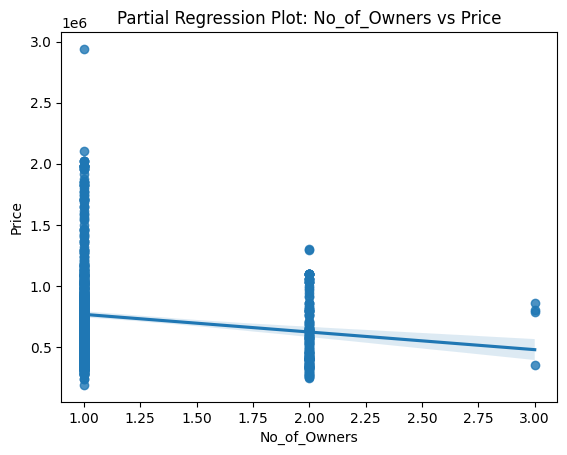

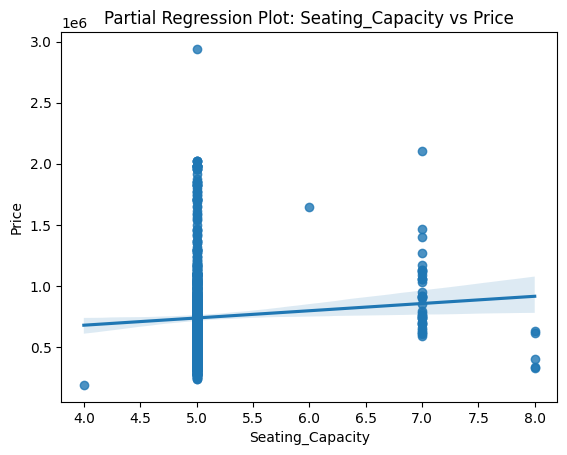

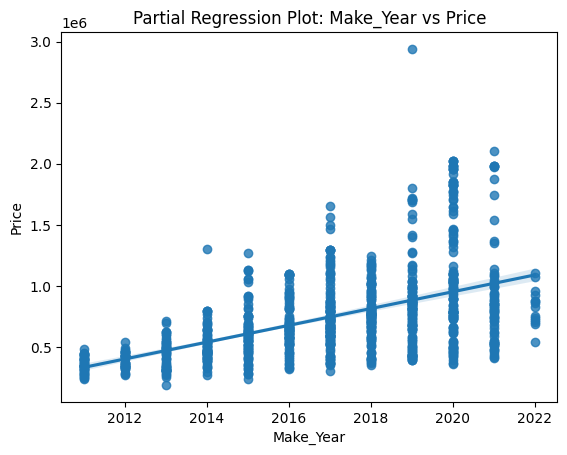

In [23]:
for feature in ['Mileage_Run','No_of_Owners','Seating_Capacity','Make_Year']:
  sns.regplot(car,x=feature,y='Price')
  plt.title(f"Partial Regression Plot: {feature} vs Price")
  plt.xlabel(feature)
  plt.ylabel("Price")
  plt.show()

#None seem to do particularly well, but # of owners and make year have a more consistent linear relationship when compared to price
    #compared to the other numeric variables. Overall, none follow significant linear patterns

In [71]:
dummy=pd.get_dummies(car[['Make_Year','Body_Type','No_of_Owners','Seating_Capacity']],dtype='int')
expand=PolynomialFeatures(degree=2,include_bias=False)
df=expand.fit_transform(car[['Mileage_Run']])
interact=pd.DataFrame(data=df,columns=expand.get_feature_names_out())
interact=pd.concat([interact,dummy,car[['Fuel_Type','Color']]],axis=1)
interact['MileagexOwner']=interact['No_of_Owners']*interact['Mileage_Run']
interact['Mileage^2xOwner']=interact['No_of_Owners']*interact['Mileage_Run^2']
interact['YearxSeating']=interact['Make_Year']*interact['Seating_Capacity']
interact['SeatingxOwner']=interact['Seating_Capacity']*interact['No_of_Owners']
interact['MileagexSeating']=interact['Seating_Capacity']*interact['Mileage_Run']
interact['Mileage^2xSeating']=interact['Seating_Capacity']*interact['Mileage_Run^2']
interact['Price']=car['Price']

ix,ixt,iy,iyt=split(interact.iloc[:,:-1],interact['Price'],test_size=0.2,random_state=4327)
ix=pd.get_dummies(ix,dtype='int',columns=['Mileage_Run', 'Mileage_Run^2', 'Make_Year', 'No_of_Owners',
       'Seating_Capacity', 'Body_Type_crossover', 'Body_Type_hatchback',
       'Body_Type_muv', 'Body_Type_sedan', 'Body_Type_suv', 'Fuel_Type',
       'Color', 'MileagexOwner', 'Mileage^2xOwner', 'YearxSeating',
       'SeatingxOwner', 'MileagexSeating', 'Mileage^2xSeating', 'Price'])
ixt=pd.get_dummies(ixt,dtype='int',columns=['Mileage_Run', 'Mileage_Run^2', 'Make_Year', 'No_of_Owners',
       'Seating_Capacity', 'Body_Type_crossover', 'Body_Type_hatchback',
       'Body_Type_muv', 'Body_Type_sedan', 'Body_Type_suv', 'Fuel_Type',
       'Color', 'MileagexOwner', 'Mileage^2xOwner', 'YearxSeating',
       'SeatingxOwner', 'MileagexSeating', 'Mileage^2xSeating', 'Price'])
ixt=ixt.reindex(columns=ix.columns,fill_value=0)
# ireg=LinearRegression(fit_intercept=False).fit(ix,iy)
# ipred=ireg.predict(ix)
# ipredt=ireg.predict(ixt)
# irsme=np.sqrt(np.sum((ipred-iy)**2)/len(iy))
# ir2=ireg.score(ipred,iy)
# irsmet=np.sqrt(np.sum((ipredt-iyt)**2)/len(iyt))
# ir2t=ireg.score(ipredt,iyt)

# irsmet=np.sqrt(np.sum((numpred-ytest)**2)/len(ytest))
# print("R2 Train:",ir2,"\n","RSME Train:",irsme,"\n","R2 Test:",ir2t,"\n","RSME Test:",irsmet)
interact.columns

KeyError: "['Price'] not in index"